# Avoiding the cross

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Read an image

In [121]:
cd ~/Dropbox/dev/rainbow/notebooks

/Users/matt/Dropbox/dev/rainbow/notebooks


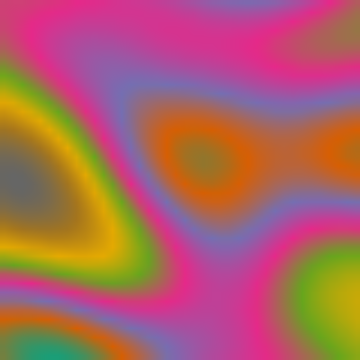

In [122]:
from PIL import Image

# img = Image.open('data/cbar/boxer.png')
# img = Image.open('data/cbar/fluid.png')
# img = Image.open('data/cbar/lisa.png')
# img = Image.open('data/cbar/redblu.png')
# img = Image.open('data/cbar/seismic.png')
# img = Image.open('data/cbar/drainage.jpg')
img = Image.open('data/cbar/test.png')

#img = Image.open('data/cbar/Colormap_Jet1.png')

img

In [123]:
img.size

(360, 360)

## Quantize with scikit

In [124]:
n_colours = 100

In [125]:
from sklearn.cluster import KMeans
from sklearn.utils import shuffle

In [126]:
im = np.asarray(img)[..., :3] / 255.

h, w, d = im.shape
im_ = im.reshape((w * h, d))

# Define training set.
n = min(h*w//50, n_colours*10)
sample = shuffle(im_, random_state=0)[:n]

In [127]:
kmeans = KMeans(n_clusters=n_colours).fit(sample)

In [128]:
p = kmeans.cluster_centers_

# I don't know why I need to do this, but I do. Floating point precision maybe.
p[p > 1] = 1
p[p < 0] = 0

## Colinearity adjustment

Approaches to try:

For each point...

- How colinear is every triangle this point makes with every other point? (Too many)
- How colinear is this point with its 2 nearest neighbours?
- How colinear are the three nearest neighbours of this point with each other? (PRobably can't disconnect a point from its colinearity coefficient like this)

In [129]:
# ALL TRIPLES
# from itertools import permutations
# triples = np.array(list(permutations(p, 3)))
# triples.shape

# There are n(n - 1) values that "belong" to each point (have it first).
# So maybe I can get a measure of the local linearity of a point

# ... OK this is all too much, let's try something else...

In [130]:
from sklearn.neighbors import BallTree
tree = BallTree(p)

# Get only the three nearest
# _, idx = tree.query(p, 4)
# idx = idx[:, 1:]   # For measuring the relationship between the 3 neighbours (not including 'self')
# triples = p[idx]

# Get 2 nearest neighbours and include 'self'
_, idx = tree.query(p, 3)
triples = p[idx]

In [131]:
colin = 1 - np.power(np.abs(np.linalg.det(triples)), 0.25)  # 1 = colinear, 0 = not at all
# Will need to scale this I think

np.max(colin)

0.9713232080882227

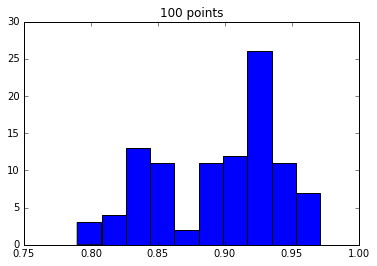

In [132]:
plt.hist(colin)
plt.plot()
plt.title('{} points'.format(colin.size))
plt.show()

In [133]:
# Now we also need a direction metric. Best thing is probably
# the spherical angle, which has two parameters: alpha and gamma.

In [309]:
def colinear(pts):
    """Area of a triangle, given an array of three 3d points.
    """
    print(pts)
    p1, p2, p3 = np.array(pts)
    co = 1 - 0.5 * np.linalg.norm(np.cross(p2 - p1, p3 - p1))
    return co

In [310]:
np.linalg.norm(np.cross(np.array([1,2,3])-np.array([6,3,9]), np.array([-1,4,3])-np.array([8,2,9])))

35.510561809129406

In [313]:
x, y, z = triples[-1]
x

array([ 0.46448802,  0.41437908,  0.3167756 ])

In [320]:
np.apply_along_axis(colinear, 1, triples)

[ 0.85826331  0.87591036  0.83191346]


ValueError: 'axisa' out of bounds

In [252]:
def orient_line(p):
    """Orientation of a line, given an array of two 3d points.
    """
    p1, p2 = np.array(p)
    line = np.abs(p1 - p2)
    unit = line / np.linalg.norm(line)

    x, y, z = unit
    pitch = np.arcsin(-y)
    yaw = np.arctan2(x, z)
    
    return np.array([pitch, yaw])

def orient_tri(points):
    """Orientation of a triangle, given an array of three 3d points.
    """
    this = []
    pairs = list(permutations(points, 2))
    for pair in [0, 1, -1]:
        this.append(orientation(pairs[pair]))
    return np.mean(this, axis=0)


In [255]:
idx[:5]

array([[ 0, 77, 21],
       [ 1, 79, 41],
       [ 2, 90, 64],
       [ 3, 78, 43],
       [ 4, 84, 42]])

In [256]:
r, c = idx.shape
result = np.zeros((r, 2))
for i, ix in enumerate(idx):
    triple = p[ix]
    this_point = 0.5 * colinear * orient_tri(t)
    result[i] += this_point
    result[ix[1]] += 0.5 * this_point
    result[ix[2]] += 0.5 * this_point
result

NameError: name 'colinear' is not defined

In [251]:
triples[3]

array([[ 0.73669468,  0.53277311,  0.07170868],
       [ 0.7092437 ,  0.51092437,  0.08459384],
       [ 0.68515406,  0.49355742,  0.09467787]])

In [242]:
np.mean(a, axis=0)

array([-0.33916425,  0.80585552])

In [236]:
from itertools import permutations
points = []
for i in triples:
    this = []
    pairs = list(permutations(i, 2))
    for pair in [0, 1, -1]:
        this.append(orientation(pairs[pair]))
    points.append(this)
points = np.array(points)

In [237]:
points

array([[[-0.21251398,  0.602133  ],
        [-0.45790565,  1.00965293],
        [-0.34707312,  0.80578064]],

       [[-0.00487242,  0.848605  ],
        [-0.16863414,  0.84030745],
        [-0.09409268,  0.8441146 ]],

       [[-0.54514003,  1.28076542],
        [-0.52219312,  1.17907136],
        [-0.53231799,  1.22116854]],

       [[-0.62434879,  1.13193703],
        [-0.60734857,  1.15156393],
        [-0.58685868,  1.17435504]],

       [[-0.08005836,  0.52268436],
        [-0.10415717,  0.49634766],
        [-0.09256178,  0.50904317]],

       [[-0.61696045,  0.58402015],
        [-0.04259713,  1.45283279],
        [-0.30469795,  1.0770753 ]],

       [[-0.01152728,  0.42583245],
        [-0.11944667,  0.53527375],
        [-0.06960971,  0.4844363 ]],

       [[-0.26024184,  1.00917283],
        [-0.27390535,  1.04777802],
        [-0.2678062 ,  1.03037683]],

       [[-0.06915104,  0.54116189],
        [-0.22566465,  0.22093267],
        [-0.74310367,  0.88708702]],

       [[-

In [197]:
# need a function that takes 3 points and returns the orientation and area of the triangle

array([-0.35312775,  0.82884906])

In [167]:
np.arccos(-11/3)

nan

In [136]:
a = np.array([[11,12,13], [21, 22, 23], [31, 32,33], [41, 42, 43], [51,52,53], [61,62,63]])
t = np.array(list(permutations(a, 3)))

## Travelling salesman problem

Remember that these points are essentially in random order:

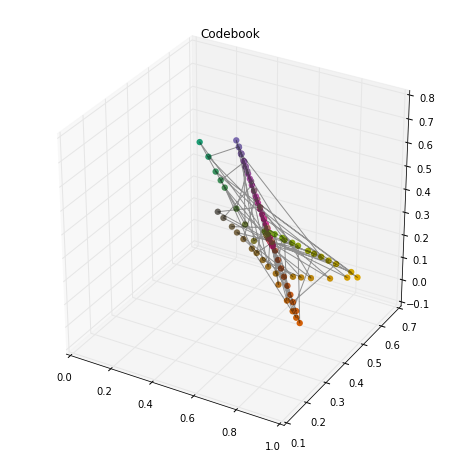

In [137]:
from mpl_toolkits.mplot3d import Axes3D

# Set up the figure
fig = plt.figure(figsize=(8, 8))

# Result of TSP solver
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*p.T, c=p, lw=0, s=40, alpha=1)
ax.plot(*p.T, color='k', alpha=0.4)
ax.set_title('Codebook')

plt.show()

In [138]:
from pytsp import run, dumps_matrix

In [139]:
p = np.vstack([[[0.25, 0, 0.5]], p])
#p = np.vstack([[[0, 0, 0]], p])

In [140]:
p[:6]

array([[ 0.25      ,  0.        ,  0.5       ],
       [ 0.85826331,  0.18655462,  0.545845  ],
       [ 0.60784314,  0.44761905,  0.15406162],
       [ 0.61719457,  0.33453997,  0.63770739],
       [ 0.73669468,  0.53277311,  0.07170868],
       [ 0.68801743,  0.39607843,  0.28627451]])

In [141]:
from scipy.spatial.distance import pdist, squareform

# Make distance matrix.
dists = squareform(pdist(p, 'euclidean'))

# The values in `dists` are floats in the range 0 to sqrt(3). 
# Normalize the values to int16s.
d = 32767 * dists / np.sqrt(3)
d = d.astype(np.int16)

# To use a TSP algo to solve the shortest Hamiltonian path problem,
# we need to add a point that is zero units from every other point.
row, col = dists.shape
d = np.insert(d, row, 0, axis=0)
d = np.insert(d, col, 0, axis=1)

The zero-point trick is legit. [Reference](http://stackoverflow.com/questions/6733999/what-is-the-problem-name-for-traveling-salesman-problemtsp-without-considering) from E. L. Lawler, Jan Karel Lenstra, A. H. G. Rinnooy Kan, D. B. Shmoys (1985). The Traveling Salesman Problem: A Guided Tour of Combinatorial Optimization, 1st Edition. Wiley. 476 pp. ISBN 978-0471904137.

In [142]:
d

array([[    0, 12067, 12663, ..., 10958,  9483,     0],
       [12067,     0, 10088, ...,  6708,  9635,     0],
       [12663, 10088,     0, ...,  4154,  4150,     0],
       ..., 
       [10958,  6708,  4154, ...,     0,  3513,     0],
       [ 9483,  9635,  4150, ...,  3513,     0,     0],
       [    0,     0,     0, ...,     0,     0,     0]], dtype=int16)

LKH implementation.

K. Helsgaun (2009). General k-opt submoves for the Lin-Kernighan TSP heuristic. Mathematical Programming Computation, 2009, doi: 10.1007/s12532-009-0004-6.

In [143]:
outf = "/tmp/myroute_lkh.tsp"
with open(outf, 'w') as f:
    f.write(dumps_matrix(d, name="My Route"))

In [144]:
tour_lkh = run(outf, start=0, solver="LKH")

In [145]:
#result = np.array(tour_concorde['tour'])
result = np.array(tour_lkh['tour'])

In [146]:
result

array([  0,  97,  11, 100,  45,  26,  72,  38,  80,   2,  31,  93,  34,
        99,  37,  96,  18,  95,  35,  63,   9,  90,  82,  92,  67,  53,
        81,  21,  68,  28,  65,   3,  91,  10,  59,  27,  50,  15,  88,
        52,  47,  22,   1,  74,  78,  56,  89,  20,  39,  77,  12,  46,
        98,  17,  61,  85,   5,  43,  60,  25,  66,   7,  58,  64,  24,
        71,  33,  48,  75,  42,  44,  79,   4,  40,  16,  51,  86,  57,
        13,  83,  32,  84,  23,  55,  49,  41,   6,  70,  76,  36,  14,
        94,  19,  69,  29,  62,  73,   8,  87,  54,  30, 101])

In [147]:
result.size  # Should be n_colours + 2

102

In [148]:
# e = np.asscalar(np.where(result == result.size-1)[0])

# if e == 1:
#     # Then it's second and I think I know why.
#     # As long as it went to the last point next, and I think
#     # it necessarily does, then we're good.
#     print("Zero-point is second. Probably dealt with it.")
#     result = np.concatenate([result[:e], result[e+1::][::-1]])
# elif e == len(result)-1:
#     # Then it's at the end already.
#     print("Zero-point is at the end. Dealt with it.")
#     result = result[:-1]
# else:
#     # I'm not sure why this would happen... but I Think in this
#     # case we can just skip it.
#     print("Zero-point is somewhere weird. Maybe dealt with... BE CAREFUL.")
#     result = result[result != result.size-1]
    
# assert len(result) == len(p)

Now `result` is the indices of points for the shortest path, shape `(256,)`. And `p` is our quantized colormap, shape `(256, 3)`. So we can select the points easily for an ordered colourmap.

The offsets are to account for the fact that we added a dark-blue point at the start and a zero point at the end.

In [149]:
c = p[result[1:-1]]

Ideally I'd like all the distances too, but it wouldn't be too hard to compute these.

Now let's look at it all.

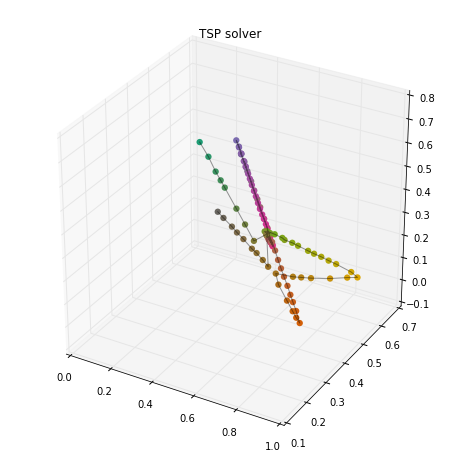

In [150]:
from mpl_toolkits.mplot3d import Axes3D
# Set up the figure
fig = plt.figure(figsize=(8, 8))

# Result of TSP solver
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*c.T, c=c, lw=0, s=40, alpha=1)
ax.plot(*c.T, color='k', alpha=0.4)
ax.set_title('TSP solver')

plt.show()

Check below an interactive version of the 3D plot. May help when there are complicated paths between points. You need to install plotly and colorlover (with pip) if you don't already have them.

In [151]:
import plotly.graph_objs as go
import colorlover as cl
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

cb = cl.to_rgb(tuple(map(tuple, c*255)))
trace = go.Scatter3d(
        name='TSP Sover',
        x = c[:,0], y = c[:,1], z = c[:,2],
        marker = dict(
            size=4.,
            color=cb
        ),
        line=dict(
            color='#000',
            width=1,
        ),
        )
data = [trace]

# Set the different layout properties of the figure:
layout = go.Layout(
    autosize=False,
    width=600,
    height=600,
    margin = dict(
        t=0,b=0,l=0,r=0
    ),
    scene = go.Scene(
        xaxis=dict(
            title='red',
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 0, 0)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        yaxis=dict(
            title='green',
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(0, 255, 0)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        zaxis=dict(
            title='blue',
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(0, 0, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        aspectmode='cube',
        camera=dict( 
            eye=dict(
                x=1.7,
                y=-1.7,
                z=1,
            )
        ),
    )
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, show_link=False)

In [152]:
np.save('/Users/matt/Dropbox/public/raw_data.npy', p[1:])
np.save('/Users/matt/Dropbox/public/ordered_data.npy', c)

In [42]:
from scipy.spatial import cKDTree

kdtree = cKDTree(c)

In [43]:
dx, ix = kdtree.query(im)

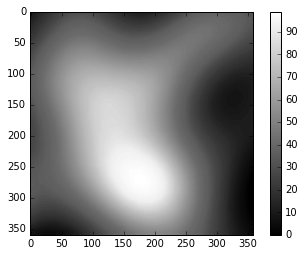

In [44]:
plt.imshow(ix, cmap='gray')
plt.colorbar()
plt.show()

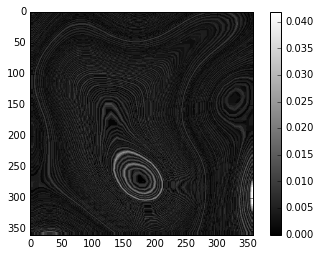

In [45]:
plt.imshow(dx, cmap='gray')
plt.colorbar()
plt.show()

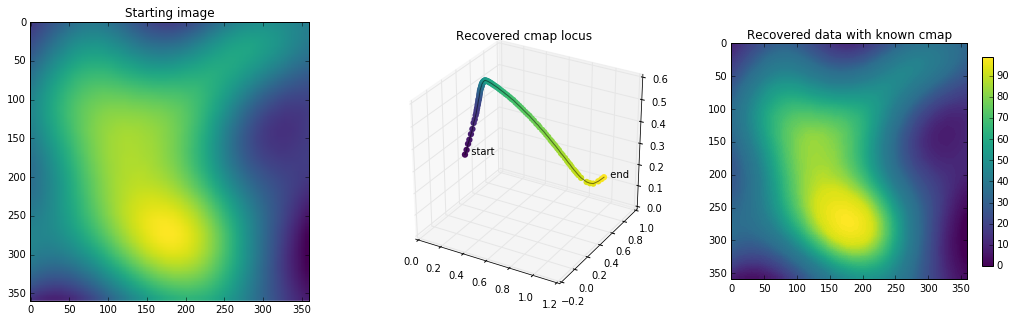

In [48]:
fig = plt.figure(figsize=(18, 5))

ax0 = fig.add_subplot(131)
plt.imshow(im, interpolation='none')
ax0.set_title("Starting image")

ax1 = fig.add_subplot(132, projection='3d')
ax1.scatter(*c.T, c=c, lw=0, s=40, alpha=1)
ax1.plot(*c.T, color='k', alpha=0.5)
ax1.text(*c[0], '  start')
ax1.text(*c[-1], '  end')
ax1.set_title("Recovered cmap locus")

ax2 = fig.add_subplot(133)
plt.imshow(ix, cmap='viridis', interpolation='none')
plt.colorbar(shrink=0.75)
ax2.set_title("Recovered data with known cmap")

plt.show()

In [49]:
cmaps = [('Perceptually Uniform Sequential',
                            ['viridis', 'inferno', 'plasma', 'magma']),
         ('Sequential',     ['Blues', 'BuGn', 'BuPu',
                             'GnBu', 'Greens', 'Greys', 'Oranges', 'OrRd',
                             'PuBu', 'PuBuGn', 'PuRd', 'Purples', 'RdPu',
                             'Reds', 'YlGn', 'YlGnBu', 'YlOrBr', 'YlOrRd']),
         ('Sequential (2)', ['afmhot', 'autumn', 'bone', 'cool',
                             'copper', 'gist_heat', 'gray', 'hot',
                             'pink', 'spring', 'summer', 'winter']),
         ('Diverging',      ['BrBG', 'bwr', 'coolwarm', 'PiYG', 'PRGn', 'PuOr',
                             'RdBu', 'RdGy', 'RdYlBu', 'RdYlGn', 'Spectral',
                             'seismic']),
         ('Qualitative',    ['Accent', 'Dark2', 'Paired', 'Pastel1',
                             'Pastel2', 'Set1', 'Set2', 'Set3']),
         ('Miscellaneous',  ['gist_earth', 'terrain', 'ocean', 'gist_stern',
                             'brg', 'CMRmap', 'cubehelix',
                             'gnuplot', 'gnuplot2', 'gist_ncar',
                             'nipy_spectral', 'jet', 'rainbow',
                             'gist_rainbow', 'hsv', 'flag', 'prism'])]